## Benchmarking the promoter sequences of the CRISPROff Screen

In [5]:
import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 
import pprint
import requests

n_sequences = 20883


In [6]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

np.set_printoptions(threshold=sys.maxsize)


### Import Sequences from server

In [8]:
Data = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)
Data = Data.sort_values(["gene",'average phenotype of strongest 3'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')
UCSC_TSS = pd.read_csv('UCSC_TSS.txt', delimiter = '\t',header = 0)
UCSC_TSS = UCSC_TSS.drop_duplicates() 

errors = []

for gene in (Data['gene']):
        try:
                if len(UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"]) > 1:
                        x = abs(UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"] - Data[Data['gene'] == gene]["Primary TSS, 3'"].iloc[-1]).min()
                        Data.loc[Data['gene'] == gene, "Primary TSS, 3'"] = (int(Data[Data['gene'] == gene]["Primary TSS, 3'"].iloc[-1] - int(x) + 1))
                else:
                        x = UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"].iloc[-1]
                        Data.loc[Data['gene'] == gene, "Primary TSS, 3'"] = int(x) + 1 
              

        except:
            errors.append(gene)

len(errors)

1568

In [9]:
Data = Data.reset_index()

In [1096]:
pp = pprint.PrettyPrinter()

b = []

for i, x in enumerate(Data['gene']):
    try:
        datas = requests.get('http://togows.org/api/ucsc/hg19/'+ str(Data['chromosome'][i])+':'+str(int(Data["Primary TSS, 3'"][i]-1500))+'-'+str(Data["Primary TSS, 3'"][i]+1500)).text.replace('\n','')    
        b.append(Data['gene'][i])
        b.append(datas)
    except:
        print('There was an error with:',Data['gene'][i],'. With coordinates:', Data['chromosome'][i], Data["Primary TSS, 3'"][i])

#It took 106 minutes to comlpete all the sequences for 2.5 kb, but this run was with 3 kb

There was an error with: DHX15 . With coordinates: chr4 24529088
There was an error with: SPATA25 . With coordinates: chr20 44515130
There was an error with: SPG20 . With coordinates: chr13 36920574


### Save the ~20,000 Sequences into a file

In [1141]:
Promoter_sequences = pd.DataFrame()

for i in range(len(b)):
    Promoter_sequences[i] = pd.DataFrame(b)

Promoter_sequences = pd.DataFrame(b[::2], columns= ['Gene'])
Promoter_sequences['Sequences'] = b[1::2]

Promoter_sequences

Promoter_sequences.to_csv(r'3kb_Promoter.sequences-2.csv') # this was done after the sequences were updated with the actual TSS

TypeError: object of type 'numpy.float64' has no len()

In [10]:
Promoter_sequences = pd.read_csv('3kb_Promoter.sequences-2.csv', sep=',', header = 0)
#Promoter_sequences  = pd.concat([Promoter_sequences, Data], axis =1, join="inner")
#Promoter_sequences = Promoter_sequences.drop_duplicates(subset = 'Gene')
Promoter_sequences = pd.merge(how = 'outer', left = Promoter_sequences, right = Data, left_on = 'Gene', right_on = 'gene')
Promoter_sequences = Promoter_sequences.dropna()

### Benchmark for the %GC Rich content

In [11]:
counts = Promoter_sequences.Sequences.apply(lambda x: (x.count('G') + x.count('C'))/30)
counts

0        56.866667
1        39.033333
2        40.366667
3        45.866667
4        58.600000
           ...    
19181    53.433333
19182    49.000000
19183    65.800000
19184    46.866667
19185    32.200000
Name: Sequences, Length: 18902, dtype: float64

### Load data from suppelemntal figures of paper

Table S3. A list of sgRNA protospacer sequences and calculated phenotype scores from the genome-wide CRISPRoff screens, related to Figure 4.

In [12]:
cpgs = pd.read_csv('1-s2-S0092867421003536-mmc3.csv',sep = ',',  header = 0)
cpgs = pd.DataFrame(cpgs)

(-0.8, 0.2, -0.8, 0.2)

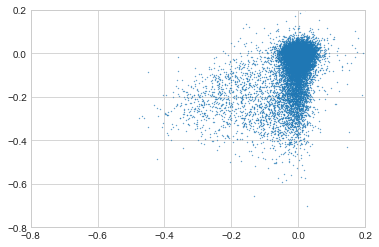

In [37]:
# from math import sqrt

# for i in range(21240):

#     if CpGs['mutant_average'][i] > CpGs['CRISPRoff_average'][i]:
#         CpGs.at[i, 'Phe_sco_pos_neg'] =  int(1)
#         CpGs.at[i,'Strength'] =  sqrt(abs(CpGs['mutant_average'][i] - CpGs['CRISPRoff_average'][i])) 

#     elif CpGs['mutant_average'][i] < CpGs['CRISPRoff_average'][i]:
#         CpGs.at[i, 'Phe_sco_pos_neg'] = int(0)
#         CpGs.at[i,'Strength'] = 0
#     else:
#         CpGs.at[i, 'Strength'] = 'Same'

import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(cpgs['mutant_average'], cpgs['CRISPRoff_average'],s = 0.1)
         
plt.axis([-0.8,0.2,-0.8,0.2])


In [13]:
cpgs = cpgs[['gene','CRISPRoff_average', 'mutant_average']]
cpgs = cpgs.sort_values(["gene",'CRISPRoff_average'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')

### Merging sequences with correspondent phenotype scores

In [14]:
df = pd.merge(how = 'outer', left = Promoter_sequences, right = cpgs, left_on = 'Gene', right_on = 'gene')
df = df.loc[df.Gene.notna()]
df['GC'] = counts
df

,Unnamed: 0,Gene,Sequences,index,gene_x,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'",CpG_location,CpG_near_TSS,CpG_overlap_TSS,Mann-Whitney p-value,average phenotype of strongest 3,sgRNA count_MW,sgRNA count_avg,-log10 MW,discScore,thres,gene_y,CRISPRoff_average,mutant_average,GC
0,0.0,A1BG,CAAGGAAAACCACTATTAGATATGTCTACATACCTATTAGAATGGC...,1.0,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822.0,58858172.0,58864822.0,58864847.0,[],False,False,0.360098,0.000262,10.0,10.0,0.443579,0.006050,False,A1BG,-0.063267,-0.013067,56.866667
1,1.0,A1CF,TGGGTTAAGCACTGTAAAGTTGTTATAGCAATAAACCTATGAAATA...,2.0,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379.0,52601584.0,52645379.0,52645393.0,[],False,False,0.145156,-0.009390,10.0,10.0,0.838166,0.409634,False,A1CF,0.021009,0.031239,39.033333
2,2.0,A2M,GCAACATGCCCCTTGCTCCCCACAGGGAGAGAAGAGCTCTGGCCCT...,3.0,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507.0,9220304.0,9268528.0,9268542.0,[],False,False,0.109319,-0.023705,9.0,9.0,0.961305,1.186075,False,A2M,0.012236,0.010139,40.366667
3,3.0,A2ML1,AAGGATTTAAGTAATAATAAAACTCCAGTCTCCCACACAGCCGGCT...,4.0,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206.0,8975150.0,8975144.0,8975169.0,[],False,False,0.436220,-0.003734,10.0,10.0,0.360295,0.070022,False,A2ML1,0.006076,0.017281,45.866667
4,4.0,A3GALT2,CCTGCTATCGCCCCCAGGCCAGAAAATGTCATTTTGGACTTTGTCT...,5.0,A3GALT2,ENST00000442999.3,chr1,-,Annotation,33786698.0,33772367.0,33786698.0,33786698.0,[],False,False,0.881354,-0.007984,10.0,10.0,0.054850,0.022794,False,A3GALT2,0.045413,0.018161,58.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18897,19181.0,ZYG11A,ATTGGGCAAAAGCCGAGGAAATGACTGTAACTTTCCTTCATCCTCG...,20739.0,ZYG11A,P1P2,chr1,+,"CAGE, matched peaks",53308425.0,53308183.0,53308505.0,53308544.0,"[[53308294, 53309262]]",False,True,0.877678,0.021245,10.0,10.0,0.056665,0.062657,False,ZYG11A,0.020289,-0.005404,47.033333
18898,19182.0,ZYG11B,GAACTGAGGAGGATTTGATGTTAGCTAAAAGACAAATAATTAACTT...,20740.0,ZYG11B,P1P2,chr1,+,"CAGE, matched peaks",53192114.0,53192131.0,53192160.0,53192181.0,"[[53192023, 53192428]]",False,True,0.010769,-0.039053,10.0,10.0,1.967841,3.999912,False,ZYG11B,0.012916,-0.027637,38.300000
18899,19183.0,ZYX,GAGCAGGGGAGAATGAAGAGGCGTCAGTTTGGGCATCAGGCTGGAT...,20741.0,ZYX,P1P2,chr7,+,"CAGE, matched peaks",143078379.0,143078360.0,143078652.0,143078754.0,"[[143077469, 143079169]]",False,True,0.860029,-0.002571,10.0,10.0,0.065487,0.008762,False,ZYX,0.004499,0.013557,52.766667
18900,19184.0,ZZEF1,ATCTCTATTTCCACATGTCCAAAATGACTAACGGAGAAATGTACAA...,20742.0,ZZEF1,P1P2,chr17,-,"CAGE, matched peaks",4046257.0,3979246.0,4046248.0,4046251.0,"[[4045792, 4047367]]",False,True,0.513333,0.017460,10.0,10.0,0.289601,0.263182,False,ZZEF1,0.029630,0.003709,49.066667


In [40]:
df['GC'] = df['GC'].apply(lambda x: 0 if x < 50 else x)

/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_79288/1166661427.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


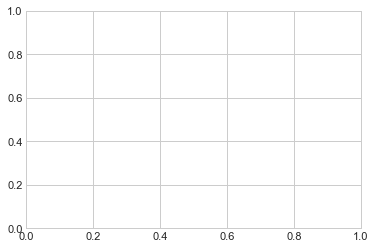

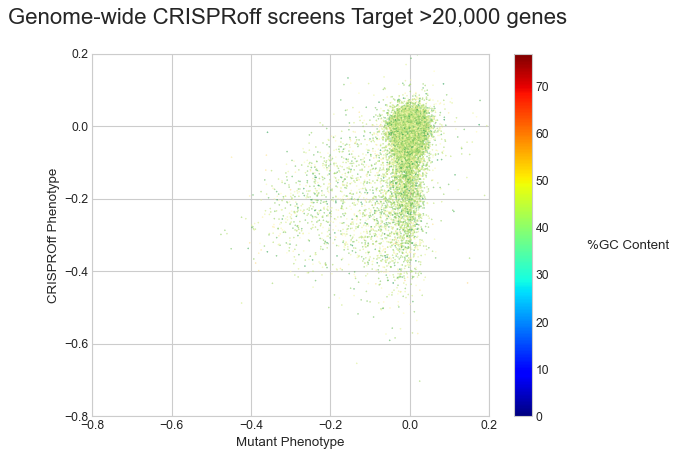

In [58]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.pyplot import figure

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

figure(figsize=(8, 6), dpi=80)

colors = {1:'tab:pink', 0:'tab:black', 'Nan':'tab:blue'}

plt.scatter(df['mutant_average'], df['CRISPRoff_average'], c = df.GC, cmap = "RdYlGn",s = 0.1)

normalize = mcolors.Normalize(vmin=df.GC.min(), vmax=df.GC.max())
colormap = cm.jet

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.GC)
plt.colorbar(scalarmappaple)

plt.legend(bbox_to_anchor=(1.35,0.5), borderaxespad=0, title="%GC Content",
                    loc= 'upper center', fontsize='small', fancybox=True,)

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Phenotype')

plt.axis([-0.8,0.2,-0.8,0.2])
plt.savefig('Genome-wide %GC.eps', format = 'eps')


/var/folders/pj/0dd0rqzj219164nwyh4f2l580000gn/T/ipykernel_79288/1064701637.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(scalarmappaple)


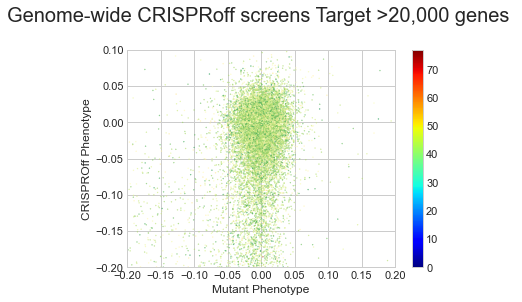

In [59]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df['mutant_average'], df['CRISPRoff_average'], c = df.GC, cmap = "RdYlGn",s = 0.1)

normalize = mcolors.Normalize(vmin=df.GC.min(), vmax=df.GC.max())
colormap = cm.jet

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Phenotype')

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(df.GC)
plt.colorbar(scalarmappaple)

plt.title('Genome-wide CRISPRoff screens Target >20,000 genes \n', size = 20)
plt.xlabel('Mutant Phenotype')
plt.ylabel('CRISPROff Phenotype')

plt.axis([-0.2,0.2,-0.2,0.1])
plt.savefig('Genome-Wide %GC Zoom.eps', format = 'eps')


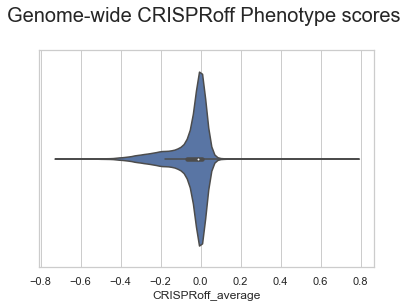

In [43]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
plt.title('Genome-wide CRISPRoff Phenotype scores \n', size = 20)
ax = sns.violinplot(x=df['CRISPRoff_average'])
plt.savefig('Violin plot.eps', format = 'eps')

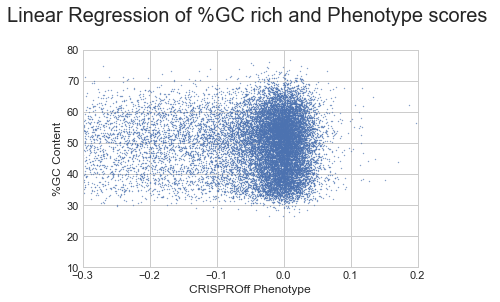

In [60]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df['CRISPRoff_average'], df['GC'], cmap = "RdYlGn",s = 0.1)

plt.xlabel('CRISPROff Phenotype')
plt.ylabel('%GC Content')

plt.title('Linear Regression of %GC rich and Phenotype scores \n', size = 20)

plt.axis([-0.3,0.2,10,80])
plt.savefig('Linear-regression_1.eps', format = 'eps')


### Linear Regression of the phenotype scores with their %GC

In [61]:
regression_data = df[['CRISPRoff_average','GC']].dropna()

coefficient of determination: 4.3537004064342355e-05
slope: [-0.61554974]
intercept: 49.560612287449345


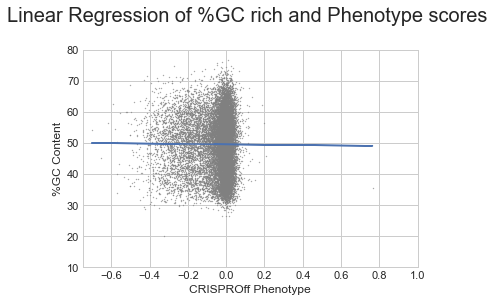

In [62]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.linear_model import LinearRegression

x =  np.array(regression_data.CRISPRoff_average).reshape((-1,1))
y =  np.array(regression_data.GC)

model = LinearRegression()
model.fit(x,y)
model = LinearRegression().fit(x,y)
r_sq = model.score(x, y)

m,b = np.polyfit(np.array(regression_data.CRISPRoff_average),y,1)

print('coefficient of determination:', r_sq)
print('slope:', model.coef_)
print('intercept:', model.intercept_)

fig, ax = plt.subplots()
plt.style.use('seaborn-whitegrid')

plt.scatter(df['CRISPRoff_average'], df['GC'],s = 0.1, c = 'grey')


plt.title('Linear Regression of %GC rich and Phenotype scores \n', size = 20)
plt.xlabel('CRISPROff Phenotype')
plt.ylabel('%GC Content')
plt.plot(x, m*x + b)

plt.axis([-0.75,1,10,80])
plt.savefig('good.eps', format = 'eps')


In [96]:
Cpgs_TSS = [False, True]

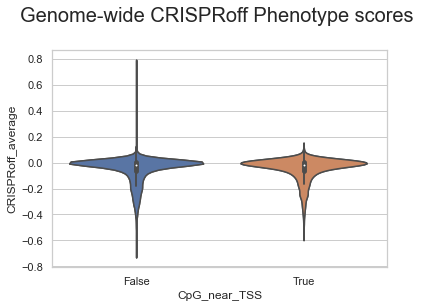

In [114]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

plt.title('Genome-wide CRISPRoff Phenotype scores \n', size = 20)

for i in Cpgs_TSS:
    sns.violinplot(data = df, x= 'CpG_near_TSS', y = 'CRISPRoff_average', split=True)

plt.savefig('Violin plot.eps', format = 'eps')



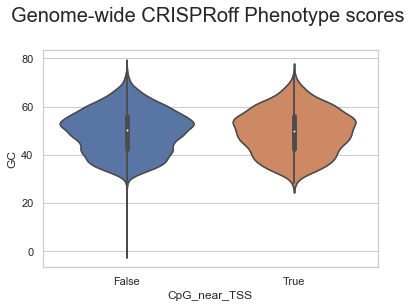

In [113]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

plt.title('Genome-wide CRISPRoff Phenotype scores \n', size = 20)

for i in Cpgs_TSS:
    sns.violinplot(data = df, x= 'CpG_near_TSS', y = 'GC', split=True)

#plt.savefig('Violin plot.eps', format = 'eps')



### KMERs and GC 


In [451]:
kmer_length = 2

def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

# Promoter_sequences['kmers'] = Promoter_sequences.Sequences.apply(lambda x: getKmers(x, kmer_length))
# Promoters_text = list(Promoter_sequences.kmers)

# for item in range(len(Promoter_sequences)):
#     Promoters_text[item] = ' '.join(Promoter_sequences.kmers[item])

In [ ]:
def Count_kmer(a_table, gc_elements, kmer):

    for sequence in a_table:

        sequence = getKmers(str(sequence), kmer)

        gc_kmers = []
        gc_counts = Counter(sequence)

        for index, element in enumerate(gc_elements):

            if element in (dict(gc_counts)):
                gc_kmers.append((dict(gc_counts)[gc_elements[index]]))
            
            else:
                print(element, 'not in kmers')

        return(sum(gc_kmers)/3000*100)

#Promoter_sequences['kmers'] = Promoter_sequences.Sequences.apply(lambda x: Count_kmer(x, ['gg','cc','gc','cg'], 2))

for i in Promoter_sequences.Sequences[:1]:
    #Count_kmer(i, ['gg','cc','gc','cg'], 2)
    print(i)

In [513]:
Promoter_sequences

,level_0,Unnamed: 0,Gene,Sequences,index,gene,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'",CpG_location,CpG_near_TSS,CpG_overlap_TSS,Mann-Whitney p-value,average phenotype of strongest 3,sgRNA count_MW,sgRNA count_avg,-log10 MW,discScore,thres,kmers
0,0,0.0,A1BG,CAAGGAAAACCACTATTAGATATGTCTACATACCTATTAGAATGGC...,1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58858172,58864822,58864847,[],False,False,0.360098,0.000262,10.0,10.0,0.443579,0.006050,False,0.0
1,1,1.0,A1CF,TGGGTTAAGCACTGTAAAGTTGTTATAGCAATAAACCTATGAAATA...,2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52601584,52645379,52645393,[],False,False,0.145156,-0.009390,10.0,10.0,0.838166,0.409634,False,0.0
2,2,2.0,A2M,GCAACATGCCCCTTGCTCCCCACAGGGAGAGAAGAGCTCTGGCCCT...,3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9220304,9268528,9268542,[],False,False,0.109319,-0.023705,9.0,9.0,0.961305,1.186075,False,0.0
3,3,3.0,A2ML1,AAGGATTTAAGTAATAATAAAACTCCAGTCTCCCACACAGCCGGCT...,4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975150,8975144,8975169,[],False,False,0.436220,-0.003734,10.0,10.0,0.360295,0.070022,False,0.0
4,4,4.0,A3GALT2,CCTGCTATCGCCCCCAGGCCAGAAAATGTCATTTTGGACTTTGTCT...,5,A3GALT2,ENST00000442999.3,chr1,-,Annotation,33786698,33772367,33786698,33786698,[],False,False,0.881354,-0.007984,10.0,10.0,0.054850,0.022794,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18897,19181,19181.0,ZYG11A,ATTGGGCAAAAGCCGAGGAAATGACTGTAACTTTCCTTCATCCTCG...,20739,ZYG11A,P1P2,chr1,+,"CAGE, matched peaks",53308425,53308183,53308505,53308544,"[[53308294, 53309262]]",False,True,0.877678,0.021245,10.0,10.0,0.056665,0.062657,False,0.0
18898,19182,19182.0,ZYG11B,GAACTGAGGAGGATTTGATGTTAGCTAAAAGACAAATAATTAACTT...,20740,ZYG11B,P1P2,chr1,+,"CAGE, matched peaks",53192114,53192131,53192160,53192181,"[[53192023, 53192428]]",False,True,0.010769,-0.039053,10.0,10.0,1.967841,3.999912,False,0.0
18899,19183,19183.0,ZYX,GAGCAGGGGAGAATGAAGAGGCGTCAGTTTGGGCATCAGGCTGGAT...,20741,ZYX,P1P2,chr7,+,"CAGE, matched peaks",143078379,143078360,143078652,143078754,"[[143077469, 143079169]]",False,True,0.860029,-0.002571,10.0,10.0,0.065487,0.008762,False,0.0
18900,19184,19184.0,ZZEF1,ATCTCTATTTCCACATGTCCAAAATGACTAACGGAGAAATGTACAA...,20742,ZZEF1,P1P2,chr17,-,"CAGE, matched peaks",4046257,3979246,4046248,4046251,"[[4045792, 4047367]]",False,True,0.513333,0.017460,10.0,10.0,0.289601,0.263182,False,0.0


In [503]:
[Count_kmer(Promoter_sequences.Sequences[:3], ['gg','cc','gc','cg'], 2)]

[30.9]

In [488]:
from collections import Counter

sti = ['gc','cg']

county = Counter(Promoter_sequences.kmers[0])

'ta' in dict(county)

True

### Essential Genes list across cell types

Those genes are the ‘common essential’ genes across many cell types, we predict all of those genes to cause cell death if you turn them off
so one good place to start is for those genes, get the CRISPRoff phenotypes from our paper almost all of them should be negative phenotypes
for those that are not, use some model to predict why is it bc they lack cpg islands?

In [128]:
achilles = pd.read_csv('Achilles_common_essentials.csv',sep = '(',  header = 0)
achilles = achilles['genes']

In [129]:
achilles_scores = pd.merge(how = 'inner', left = achilles, right = df, left_on = 'genes', right_on = 'Gene')
achilles_scores

,genes,Unnamed: 0,Gene,Sequences,index,gene_x,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'",CpG_location,CpG_near_TSS,CpG_overlap_TSS,Mann-Whitney p-value,average phenotype of strongest 3,sgRNA count_MW,sgRNA count_avg,-log10 MW,discScore,thres,gene_y,CRISPRoff_average,mutant_average,GC
0,AAAS,7.0,AAAS,TCCCAGTGGGCAGAGGGGGAGCCTCGATATGCACTGACCACTACCC...,8.0,AAAS,P1P2,chr12,-,"CAGE, matched peaks",53715328.0,53701240.0,53715027.0,53715096.0,"[[53715133, 53715516]]",False,True,5.668507e-01,-0.002647,10.0,10.0,0.246531,0.033971,False,AAAS,0.022066,0.033454,53.533333
1,AAMP,18.0,AAMP,GGAGGACACGACCTGCAGCCCCATCCTAACTCTGGCCACCCCATCC...,19.0,AAMP,P1P2,chr2,-,"CAGE, matched peaks",219134822.0,219128852.0,219134430.0,219134472.0,"[[219134787, 219135393]]",False,True,3.656279e-01,-0.106020,10.0,10.0,0.436961,2.411217,False,AAMP,-0.156843,-0.107485,61.333333
2,AARS,22.0,AARS,GCCTCCCAAAGTGCTGGGATTACAGGGGTGAGCTACCGCGCCCGGC...,23.0,AARS,P1P2,chr16,-,"CAGE, matched peaks",70323383.0,70323421.0,70323422.0,70323463.0,"[[70323127, 70323489]]",False,True,7.486399e-08,-0.449801,10.0,10.0,7.125727,166.823065,True,AARS,-0.262698,-0.276756,52.933333
3,AARS2,23.0,AARS2,GAAGCTTCCGCACCCGCGGGAGGGATTACAGCCCTCGGGTGATGGG...,24.0,AARS2,P1P2,chr6,-,"CAGE, matched peaks",44281043.0,44266463.0,44281043.0,44281091.0,"[[44280719, 44281198]]",False,True,1.433062e-04,-0.164648,10.0,10.0,3.843735,32.939366,True,AARS2,-0.143610,0.000784,57.366667
4,AASDHPPT,26.0,AASDHPPT,AAAAATCAGTTTAAAACGACAAGAAGGAAAGGTTATATGATTCTTA...,28.0,AASDHPPT,P1P2,chr11,+,"CAGE, matched peaks",105948366.0,105948292.0,105948420.0,105948438.0,"[[105948097, 105948830]]",False,True,4.364675e-02,-0.061442,10.0,10.0,1.360048,4.349363,False,AASDHPPT,-0.299343,-0.029740,47.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,ZNRD1,19129.0,ZNRD1,AAAATATAACTTATAACTTGTTTTCATGGTTTCAGGCACTGCCTAC...,20682.0,ZNRD1,P1P2,chr6,+,"CAGE, matched peaks",30029062.0,1541142.0,30029008.0,30029055.0,"[[30028936, 30029195]]",False,True,5.797046e-06,-0.279421,10.0,10.0,5.236793,76.160604,True,ZNRD1,-0.264723,-0.206160,58.500000
2026,ZRANB2,19142.0,ZRANB2,ACACTTTTCCTCTGTGTAGGAAGTGACAAGAAAGACACTTTTCCTC...,20696.0,ZRANB2,P1P2,chr1,-,"CAGE, matched peaks",71546690.0,71528974.0,71546949.0,71546984.0,"[[71546486, 71546783]]",False,True,4.500723e-01,0.011037,10.0,10.0,0.346718,0.199175,False,ZRANB2,-0.113596,-0.040849,47.333333
2027,ZRSR2,19144.0,ZRSR2,AAAGCAGAGTGATTTACCTAAAACACAAACACAACCACAATAAGCC...,20698.0,ZRSR2,P1P2,chrX,+,"CAGE, matched peaks",15808569.0,15808574.0,15808255.0,15808274.0,"[[15808190, 15808824]]",False,True,2.426390e-06,-0.077010,10.0,10.0,5.615039,22.506521,True,ZRSR2,-0.162753,-0.028557,44.533333
2028,ZW10,19175.0,ZW10,CCAACCTAGTATAAACTATTCATTAGGTGAAACAGTCCCGAGGGAC...,20733.0,ZW10,P1P2,chr11,-,"CAGE, matched peaks",113644390.0,113603905.0,113644481.0,113644490.0,"[[113644299, 113644657]]",False,True,9.063771e-04,-0.134235,10.0,10.0,3.042691,21.258350,True,ZW10,-0.245077,0.034984,50.400000


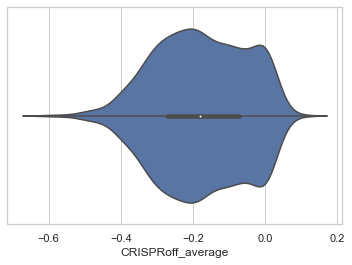

In [130]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x=achilles_scores['CRISPRoff_average'])
plt.savefig('Essential Genes list.eps', format = 'eps')

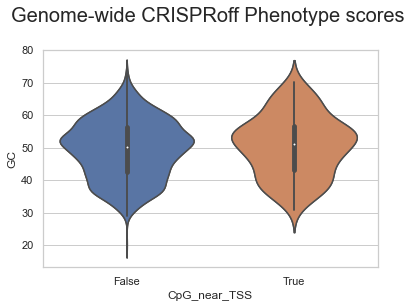

In [131]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()

plt.title('Genome-wide CRISPRoff Phenotype scores \n', size = 20)

for i in Cpgs_TSS:
    sns.violinplot(data = achilles_scores, x= 'CpG_near_TSS', y = 'GC', split=True)

#plt.savefig('Violin plot.eps', format = 'eps')



In [31]:
achilles_cpgs = pd.merge(how = 'outer', left = achilles_scores, right = cpgs, left_on = 'genes', right_on = 'gene')
achilles_cpgs = achilles_cpgs.dropna()

In [32]:
achilles_cpgs

,genes,gene_x,CRISPRoff_average_x,mutant_average_x,gene_y,CRISPRoff_average_y,mutant_average_y
0,AAAS,AAAS,0.022066,0.033454,AAAS,0.022066,0.033454
1,AAMP,AAMP,-0.156843,-0.107485,AAMP,-0.156843,-0.107485
2,AARS,AARS,-0.262698,-0.276756,AARS,-0.262698,-0.276756
3,AARS2,AARS2,-0.143610,0.000784,AARS2,-0.143610,0.000784
4,AASDHPPT,AASDHPPT,-0.299343,-0.029740,AASDHPPT,-0.299343,-0.029740
...,...,...,...,...,...,...,...
2158,ZNRD1,ZNRD1,-0.264723,-0.206160,ZNRD1,-0.264723,-0.206160
2160,ZRANB2,ZRANB2,-0.113596,-0.040849,ZRANB2,-0.113596,-0.040849
2161,ZRSR2,ZRSR2,-0.162753,-0.028557,ZRSR2,-0.162753,-0.028557
2162,ZW10,ZW10,-0.245077,0.034984,ZW10,-0.245077,0.034984


In [33]:
cpgs = pd.read_csv('1-s2-S0092867421003536-mmc3.csv',sep = ',',  header = 0)
cpgs = cpgs[['gene','CRISPRoff_average', 'mutant_average','CpG']]
cpgs = cpgs.sort_values(["gene",'CRISPRoff_average'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')
#cpgs['CpG'] = cpgs['CpG'].apply(lambda x:  1 if 'VERDADERO' else 0)

In [34]:
cpgs[cpgs.CpG == 'FALSO']

,gene,CRISPRoff_average,mutant_average,CpG
18757,44086,0.023959,0.017189,FALSO
18682,44088,0.023584,0.012517,FALSO
19763,44166,0.031839,0.025885,FALSO
18251,A1CF,0.021009,0.031239,FALSO
16516,A2M,0.012236,0.010139,FALSO
...,...,...,...,...
14459,ZSWIM1,0.003963,0.001552,FALSO
3162,ZSWIM3,-0.125409,0.001949,FALSO
12831,ZUFSP,-0.002342,-0.002830,FALSO
2729,ZWILCH,-0.148659,-0.113377,FALSO


In [35]:
achilles_cpgs = pd.merge(how = 'outer', left = achilles_scores, right = cpgs, left_on = 'genes', right_on = 'gene')
achilles_cpgs = achilles_cpgs.dropna()

In [36]:
achilles_cpgs

,genes,gene_x,CRISPRoff_average_x,mutant_average_x,gene_y,CRISPRoff_average_y,mutant_average_y,CpG
0,AAAS,AAAS,0.022066,0.033454,AAAS,0.022066,0.033454,VERDADERO
1,AAMP,AAMP,-0.156843,-0.107485,AAMP,-0.156843,-0.107485,VERDADERO
2,AARS,AARS,-0.262698,-0.276756,AARS,-0.262698,-0.276756,VERDADERO
3,AARS2,AARS2,-0.143610,0.000784,AARS2,-0.143610,0.000784,VERDADERO
4,AASDHPPT,AASDHPPT,-0.299343,-0.029740,AASDHPPT,-0.299343,-0.029740,VERDADERO
...,...,...,...,...,...,...,...,...
2158,ZNRD1,ZNRD1,-0.264723,-0.206160,ZNRD1,-0.264723,-0.206160,VERDADERO
2160,ZRANB2,ZRANB2,-0.113596,-0.040849,ZRANB2,-0.113596,-0.040849,VERDADERO
2161,ZRSR2,ZRSR2,-0.162753,-0.028557,ZRSR2,-0.162753,-0.028557,VERDADERO
2162,ZW10,ZW10,-0.245077,0.034984,ZW10,-0.245077,0.034984,VERDADERO


Genes without CpGs: 133
Genes with CpGs: 1866


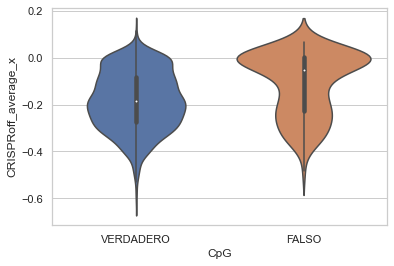

In [37]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

sns.violinplot(y='CRISPRoff_average_x', x="CpG",
              data=achilles_cpgs)

print('Genes without CpGs:', len(achilles_cpgs.CpG[achilles_cpgs.CpG == 'FALSO']))
print('Genes with CpGs:', len(achilles_cpgs.CpG[achilles_cpgs.CpG == 'VERDADERO']))

plt.savefig('Essential Genes list violin.eps', format = 'eps')

### IRRBS File

This track is produced as part of the ENCODE project. The track displays the methylation status of specific CpG dinucleotides in the given cell types as identified by the Illumina Infinium Human Methylation 450 Bead Array platform. In general, methylation of CpG sites within a promoter causes silencing of the gene associated with that promoter.

The Infinium Human Methylation 450 platform uses bisulfite treated genomic DNA to assay the methylation status of more than 450,000 CpG sites covering all designatable RefSeq genes, including promoter, 5' and 3' regions, without bias against those lacking CpG islands. Additionally, the assay includes CpG islands and shores, CpG sites outside of CpG islands, non-CpG methylated sites identified in human stem cells, differentially methylated sites identified in tumor versus normal (multiple forms of cancer) and across several tissue types, CpG islands outside of coding regions, miRNA promoter regions, and disease-associated regions identified through GWAS.

In [15]:
irbs = pd.read_csv('wgEncodeHaibMethylRrbsK562HaibSitesRep1.bed', sep='\t', header = 0)
irbs

,track,"name=""SL725","MspIRRBS""",K562_Rep3_RRBS,"MspIRRBS"".1",visibility=2,"name=""SL725.1","MspIRRBS"".2",Unnamed: 8,Unnamed: 9,Unnamed: 10
0,chr1,1000170,1000171,K562_Rep3_RRBS,46,+,1000170,1000171,"155,255,0",46,35
1,chr1,1000190,1000191,K562_Rep3_RRBS,46,+,1000190,1000191,"105,255,0",46,15
2,chr1,1000191,1000192,K562_Rep3_RRBS,53,-,1000191,1000192,"55,255,0",53,9
3,chr1,1000198,1000199,K562_Rep3_RRBS,46,+,1000198,1000199,"105,255,0",46,20
4,chr1,1000199,1000200,K562_Rep3_RRBS,53,-,1000199,1000200,"105,255,0",53,15
...,...,...,...,...,...,...,...,...,...,...,...
1275813,chrY,9930847,9930848,K562_Rep3_RRBS,28,-,9930847,9930848,"205,255,0",28,43
1275814,chrY,9930879,9930880,K562_Rep3_RRBS,28,-,9930879,9930880,"255,155,0",28,68
1275815,chrY,9982886,9982887,K562_Rep3_RRBS,5,+,9982886,9982887,"0,255,0",5,0
1275816,chrY,9987654,9987655,K562_Rep3_RRBS,7,+,9987654,9987655,"55,255,0",7,14


In [16]:
irbs.columns

Index(['track', 'name="SL725', 'MspIRRBS"', 'K562_Rep3_RRBS', 'MspIRRBS".1', 'visibility=2', 'name="SL725.1', 'MspIRRBS".2', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10'], dtype='object')

Extract all the color values for each of the basepairs

In [17]:
col = irbs['Unnamed: 8'].str.split(',')

for i, x  in enumerate(col):
   col[i] = pd.to_numeric(col[i])/255

Text(0.5, 1.0, 'DNA Methylation in Chromosomes for K562 hg19 bed file \n')

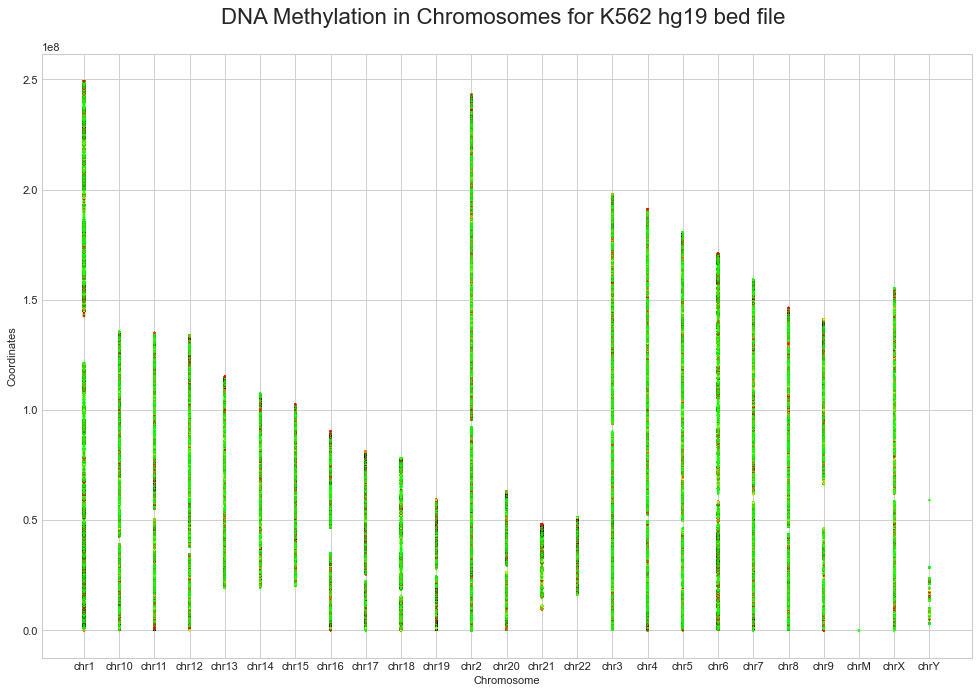

In [26]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.style.use('seaborn-whitegrid')

figure(figsize=(15, 10), dpi=80)

plt.scatter(irbs['track'], irbs['name="SL725'], c = col, s = 1)

plt.xlabel('Chromosome')
plt.ylabel('Coordinates')

plt.title('DNA Methylation in Chromosomes for K562 hg19 bed file \n', size = 20)

# plt.axis([-0.3,0.2,10,80])
# plt.savefig('Linear-regression_1.eps', format = 'eps')


Obtain all the RGB color values to plot them

In [276]:
col_keys = irbs['Unnamed: 8'].unique()

for i, x  in enumerate(col_keys):
    col_keys[i] = col_keys[i].split(',')

for i, x  in enumerate(col_keys):
   col_keys[i] = pd.to_numeric(col_keys[i])/255

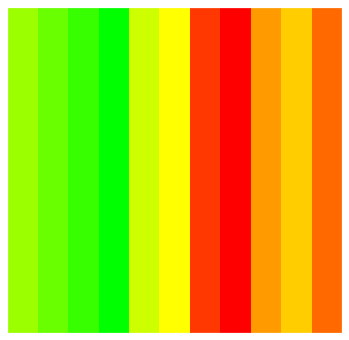

In [544]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

ax.axis(xmin=0, xmax=len(col_keys))
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

for index, colour in enumerate(col_keys):
    ax.axvspan(index, index + 1, color=colour)

#### Show only the methylation position at every basepair in the promoter sequence

Display Conventions and Configuration

Methylation status is represented with an 11-color gradient using the following convention:


- red = 100% of molecules sequenced are methylated

- yellow = 50% of molecules sequenced are methylated

- green = 0% of molecules sequenced are methylated


The score in this track reports the number of sequencing reads obtained for each CpG, which is often called 'coverage'. The score is capped at 1000, so any CpGs that were covered by more than 1000 sequencing reads have a score of 1000. The BED files available for download contain two extra columns: one with the uncapped coverage (number of reads at that site) and one with the percentage of those reads that show methylation. High reproducibility was obtained, with correlation coefficients greater than 0.9 between biological replicates, when only considering CpGs represented by at least 10 sequencing reads (10X coverage, score=10). Therefore, the default view for this track is set to 10X coverage, or a score of 10.

Metadata for a particular subtrack can be found by clicking the down arrow in the list of subtracks.

Description taken from: http://genome.ucsc.edu/cgi-bin/hgFileUi?db=hg19&g=wgEncodeHaibMethylRrbs#TRACK_HTML

In [196]:
Promoter_sequences = Promoter_sequences.reset_index()

In [167]:
# Extract only the Chromosome 1 

chr1_cpgs = irbs[irbs.track == 'chr2']

#Extract only the values with 100% Certainty of methylation 
chr1_cpgs = chr1_cpgs[chr1_cpgs['Unnamed: 8'] == '255,0,0']
chr1_cpgs

,track,"name=""SL725","MspIRRBS""",K562_Rep3_RRBS,"MspIRRBS"".1",visibility=2,"name=""SL725.1","MspIRRBS"".2",Unnamed: 8,Unnamed: 9,Unnamed: 10
670565,chr2,100008792,100008793,K562_Rep3_RRBS,5,-,100008792,100008793,"255,0,0",5,100
670566,chr2,100008798,100008799,K562_Rep3_RRBS,5,-,100008798,100008799,"255,0,0",5,100
670678,chr2,100107194,100107195,K562_Rep3_RRBS,2,+,100107194,100107195,"255,0,0",2,100
670710,chr2,100210292,100210293,K562_Rep3_RRBS,38,-,100210292,100210293,"255,0,0",38,97
670712,chr2,100210298,100210299,K562_Rep3_RRBS,38,-,100210298,100210299,"255,0,0",38,97
...,...,...,...,...,...,...,...,...,...,...,...
753354,chr2,9962378,9962379,K562_Rep3_RRBS,1,-,9962378,9962379,"255,0,0",1,100
753358,chr2,99722074,99722075,K562_Rep3_RRBS,1,+,99722074,99722075,"255,0,0",1,100
753359,chr2,99722091,99722092,K562_Rep3_RRBS,1,+,99722091,99722092,"255,0,0",1,100
753526,chr2,99960677,99960678,K562_Rep3_RRBS,1,+,99960677,99960678,"255,0,0",1,100


In [170]:
# Extract only the Promoter sequences in Chromosome 1 

chr1_ps = Promoter_sequences[Promoter_sequences.chromosome == 'chr2']


1202

Create a vector full of zeros and then fill each position with correspondent position from the 5' Transcription start in Jin's file 

In [20]:
# tmp = np.zeros((1955,3001))

# for i, x in enumerate(chr1_cpgs['name="SL725.1'][:20]):
#     for o, z in enumerate(chr1_ps["Primary TSS, 3'"]):
#         if (x > (z - 1500) and (x < (z + 1500))) == True:
#             print('CpG Islands found in:', x,'TSS Starts:', z, 'Position on vector:', x - (z - 1500),"in row", o)
#             tmp[o][x - (z - 1500)] == 1

In [169]:
chr1_ps = chr1_ps.reset_index()
chr1_ps

,level_0,Unnamed: 0,Gene,Sequences,index,gene,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'",CpG_location,CpG_near_TSS,CpG_overlap_TSS,Mann-Whitney p-value,average phenotype of strongest 3,sgRNA count_MW,sgRNA count_avg,-log10 MW,discScore,thres
0,16,16.0,AAK1,GGCGTCCAAAGAGAAGCAGTCTGGACTAAGGTAACAGAGCTGACCA...,17,AAK1,P1P2,chr2,-,"CAGE, matched peaks",69870747,69771371,69870854,69870878,"[[69869986, 69871716]]",False,True,0.236883,-0.033738,10.0,10.0,0.625466,1.098334,False
1,18,18.0,AAMP,GGAGGACACGACCTGCAGCCCCATCCTAACTCTGGCCACCCCATCC...,19,AAMP,P1P2,chr2,-,"CAGE, matched peaks",219134822,219128852,219134430,219134472,"[[219134787, 219135393]]",False,True,0.365628,-0.106020,10.0,10.0,0.436961,2.411217,False
2,33,33.0,ABCA12,ATTGTAATATCTGTAATATGGGACTATGTATCATCTTTCTCTTTTC...,36,ABCA12,P1P2,chr2,-,"CAGE, matched peaks",216003325,215796266,216003325,216003359,[],False,False,0.039012,-0.003663,10.0,10.0,1.408805,0.268560,False
3,45,45.0,ABCB11,TGGGTGCAGTCCTGCTCCCAAGGTTTTCATTTCTGTGACAAGAGCT...,49,ABCB11,P1P2,chr2,-,"CAGE, matched peaks",169887827,169779449,169887827,169887839,[],False,False,0.690874,-0.004711,10.0,10.0,0.160601,0.039382,False
4,48,48.0,ABCB6,GTGAAACCCTGTCTCTACTAAAAATACAAAACTTAGCTGGGTGTGG...,52,ABCB6,P1P2,chr2,-,"CAGE, matched peaks",220083671,220083685,220083499,220083603,"[[220082991, 220084012]]",False,True,0.426332,-0.015459,10.0,10.0,0.370252,0.297912,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,18858,18858.0,ZNF514,ATTTATCTCAGAATAAATCTCTTAAAATATTTTACCATTTGACTTT...,20388,ZNF514,P2,chr2,-,"CAGE, matched peaks",95825309,95813400,95825309,95825336,"[[95824802, 95825721]]",False,True,0.331792,0.000265,10.0,10.0,0.479134,0.006614,False
1198,18957,18957.0,ZNF638,TAAAGCATAATTTGGTAAGTCTTTGTATACAGCAGTGTTTGCAGTA...,20495,ZNF638,P1P2,chr2,+,"CAGE, matched peaks",71558882,71558885,71558882,71558936,"[[71558723, 71559525]]",False,True,0.962464,-0.002768,8.0,8.0,0.016616,0.002394,False
1199,19079,19079.0,ZNF804A,GAGACTTGCAGACTCCCCCAAGTGGATATCTGAAAAATTTAGCCAA...,20626,ZNF804A,P1P2,chr2,+,"CAGE, matched peaks",185463247,185463093,185463158,185463181,"[[185463208, 185463589]]",False,True,0.735388,-0.019344,10.0,10.0,0.133484,0.134395,False
1200,19143,19143.0,ZRANB3,TTAGAAGAGGGTGGGAAAGAAGGTCAATCATCTCTCTTAATGGCCC...,20697,ZRANB3,P1P2,chr2,-,"CAGE, matched peaks",136288740,136026532,136288113,136288170,"[[136288970, 136289715]]",True,False,0.313696,-0.024889,10.0,10.0,0.503490,0.652234,False


In [ ]:
## For one chromosome

tmp = np.zeros((len(chr1_ps),3001))

for i, x in enumerate(chr1_cpgs['name="SL725.1']):


    np.array()

    for o, z in enumerate(chr1_ps["Primary TSS, 3'"]):
        if (x > (z - 1500) and (x < (z + 1500))) == True:

            y = x - (z - 1500)

            #print((z - 1500), z,  (z + 1500))
            #print('CpG Islands found in:', x, 'Position on vector:', y,"in row", chr1_ps['gene'][o], o + 1)    
            tmp[o + 1][y] = 1

In [297]:
chromosome_list = np.unique(irbs.track)

# for chromosomes in chromosome_list[:3]:

#     tmp = np.zeros((len(table2),3001))

for sub_list in chromosome_list:
    chromosome_list["%s_n" % sub_list[0]] = sub_list[0]




IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [295]:
tmp = np.zeros((len(table2),3001))

for index, chromosomes in enumerate(chromosome_list):

    table = irbs[irbs['track'] == chromosomes]
    table2 = Promoter_sequences[Promoter_sequences.chromosome == chromosomes]
    

    for i, x in enumerate(table['name="SL725.1']):
        for o, z in enumerate(table2["Primary TSS, 3'"]):
            if (x > (z - 1500) and (x < (z + 1500))) == True:

                y = x - (z - 1500)
                
                #print((z - 1500), z,  (z + 1500))
                #print('CpG Islands found in:', x, 'Position on vector:', y,"in row", Promoter_sequences['gene'][o], o + 1)    
            
                tmp[index][o + 1][y] = 1

TypeError: Cannot interpret '1955' as a data type

In [285]:
np.unique(np.where(tmp == 1)

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  118,  119,  120,  121,
        122,  123,  124,  125,  126,  127,  128,  129,  130,  131,  132,
        133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
        144,  145,  146,  147,  148,  149,  150,  1

In [257]:
## Function to show each position for a certain gene

import matplotlib.pyplot as plt

#### Nilah recommended creating a plot for methylation near TSS (position and its phenotype score)

def methylated_basepairs(int):

    #is_c(int)

    x = Promoter_sequences.head(int).tail(1)['Gene'].iloc[-1]
    print(x, "| Coordinates of TSS:", Promoter_sequences[Promoter_sequences['Gene'] == x]["Primary TSS, 3'"].iloc[-1])
    print("Found", len([np.where(tmp[int] == 1)][0][0]) , "Methylated basepairs at positions:")
    print([np.where(tmp[int] == 1)][0][0] + Promoter_sequences[Promoter_sequences['Gene'] == x]["Primary TSS, 3'"].iloc[-1] - 1500)
    plt.title("Methylation profile for promoter region of gene: {}".format(x), size = 15)
    plt.xlabel('Position of the bases | 1500 = Start of TSS ')
    plt.ylabel('Methylation')
    plt.plot(tmp[int])

    print('chr2:',[np.where(tmp[int] == 1)][0][0][0] + Promoter_sequences[Promoter_sequences['Gene'] == x]["Primary TSS, 3'"].iloc[-1] - 1500, '-', [np.where(tmp[int] == 1)][0][0][0] + Promoter_sequences[Promoter_sequences['Gene'] == x]["Primary TSS, 3'"].iloc[-1] - 1500 + 1)

    #return([np.where(tmp[int] == 1)][0][0])

AGPAT3 | Coordinates of TSS: 45285116
Found 4 Methylated basepairs at positions:
[45286581 45286590 45286596 45286606]
chr2: 45286581 - 45286582


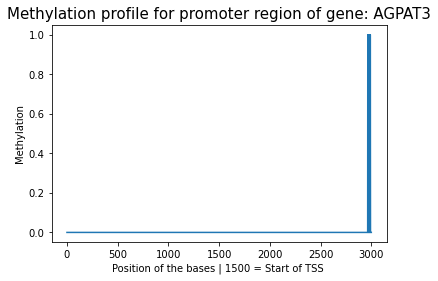

In [258]:
methylated_basepairs(406)

In [121]:
chr1_cpgs[chr1_cpgs['name="SL725.1'] == 53925469]

,track,"name=""SL725","MspIRRBS""",K562_Rep3_RRBS,"MspIRRBS"".1",visibility=2,"name=""SL725.1","MspIRRBS"".2",Unnamed: 8,Unnamed: 9,Unnamed: 10
97674,chr1,53925469,53925470,K562_Rep3_RRBS,59,+,53925469,53925470,"255,0,0",59,97


In [175]:
#np.unique([np.where(tmp == 1)])
a = np.unique(np.where(tmp == 1)[0])
a
np.where(tmp == 1)[0]

array([   2,    2,    2,    2,    2,    2,    2,    2,    5,    7,    7,
         13,   13,   13,   13,   13,   13,   13,   13,   13,   14,   14,
         14,   14,   23,   28,   28,   28,   32,   32,   32,   32,   32,
         33,   33,   33,   33,   33,   33,   33,   33,   33,   33,   33,
         33,   33,   33,   37,   45,   45,   45,   50,   50,   50,   50,
         50,   50,   50,   50,   50,   52,   52,   52,   52,   52,   57,
         57,   57,   57,   57,   57,   57,   57,   57,   57,   57,   57,
         57,   57,   57,   57,   57,   57,   57,   59,   61,   61,   64,
         72,   72,   72,   72,   72,   77,   77,   78,   78,   80,   90,
         90,   90,   90,   90,   91,   94,   94,   94,   94,   94,   97,
         97,   97,  102,  102,  102,  102,  102,  102,  102,  102,  102,
        102,  102,  102,  102,  102,  102,  102,  103,  103,  103,  103,
        103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
        103,  103,  103,  103,  103,  103,  103,  1

In [191]:
# Are the predicted methylation sites C?  

def is_c(int):
    
    counter = 0
    total = 0

    try:
        x = [np.where(tmp[int] == 1)][0][0]
        y = chr1_ps.head(int).tail(1)['Gene'].iloc[-1]

        if len(x) == 0:
            print("No Methylated Cs")
            
        for i in x:

            total += 1

            if list(chr1_ps.Sequences[chr1_ps['Gene'] == y].iloc[-1])[i] == 'C':
                #print(i, 'is a C')
                counter +=1 
            else:
                print(i, 'is not a C, its a ' + list(chr1_ps.Sequences[chr1_ps['Gene'] == y].iloc[-1])[i])
                tmp[int][i] = 0
    except:
        print("Issue with int", int, "Gene:")

    #print('Correct Cs:',counter/total*100,'%')



In [186]:
is_c(103)

1280 is not a C, its a T
1613 is a C
1618 is a C
1623 is a C
1628 is not a C, its a G
1645 is a C
1646 is a C
1661 is a C
1666 is a C
1670 is a C
1754 is a C
1755 is a C
1766 is not a C, its a A
1770 is not a C, its a G
1771 is a C
1774 is a C
1828 is a C
1834 is not a C, its a G
1850 is not a C, its a G
1859 is a C
1861 is not a C, its a G
1862 is a C
1890 is a C
1891 is a C
1940 is a C
1941 is a C
1946 is a C
1948 is not a C, its a G
1961 is a C
1978 is a C
2155 is a C
2167 is not a C, its a G
2190 is a C
2198 is a C
